# Main Question

1. Apakah perbedaan signifikan secara statistik antara perusahaan pengiriman berdasarkan waktu pengiriman ?
2. Apakah pilihan Dari Perusahaan pengiriman memiliki pengaruh pada Biaya Kargo ?


In [1]:
import mysql.connector as msc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import normaltest
from scipy.stats.mstats import winsorize
from scipy.stats import wilcoxon
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings("ignore")

## QUERY DATA DARI MYSQL

In [2]:
mydb = msc.connect(host='localhost',
                              user='root',
                              passwd='Reza233439',
                              database ='northwind')

In [3]:
mycursor=mydb.cursor()

def executedb(query):
    mycursor.execute(query)
    result = mycursor.fetchall()
    df = pd.DataFrame(result , columns= mycursor.column_names)
    return df

In [4]:
query = '''
WITH OrderCTE 
AS 
(
    SELECT o.OrderId, o.OrderDate, o.RequiredDate, o.Freight, s.CompanyName, od.UnitPrice, od.Quantity
    FROM orders o
    left join Shippers s ON o.Shipvia = s.ShipperID
    left join OrderDetails od ON o.OrderID = od.OrderID
)
SELECT * FROM OrderCTE;
'''
df = executedb(query)
df.head()

,OrderId,OrderDate,RequiredDate,Freight,CompanyName,UnitPrice,Quantity
0,10248,1996-07-04,1996-08-01,32.3800,Federal Shipping,14.0000,12
1,10248,1996-07-04,1996-08-01,32.3800,Federal Shipping,9.8000,10
2,10248,1996-07-04,1996-08-01,32.3800,Federal Shipping,34.8000,5
3,10249,1996-07-05,1996-08-16,11.6100,Speedy Express,18.6000,9
4,10249,1996-07-05,1996-08-16,11.6100,Speedy Express,42.4000,40


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   OrderId       2155 non-null   int64         
 1   OrderDate     2155 non-null   datetime64[ns]
 2   RequiredDate  2155 non-null   datetime64[ns]
 3   Freight       2155 non-null   object        
 4   CompanyName   2155 non-null   object        
 5   UnitPrice     2155 non-null   object        
 6   Quantity      2155 non-null   int64         
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 118.0+ KB


* Dataset yang digunakan merupakan tabel Orders yang  ada pada Database NorthWind
* Dari Tabel Orders, OrderDetails dan Shipper kita hanya mengambil 7 kolom

## Data Cleaning

### Missing Value

In [7]:
# Data Cleaning
# mengecek Missing Value
#df.isna().sum()/len(df.index)*100
df.isna().sum()
#df.info()

OrderId         0
OrderDate       0
RequiredDate    0
Freight         0
CompanyName     0
UnitPrice       0
Quantity        0
dtype: int64

* Berdasarkan pengecekan Missing Value tidak terdapat Missing value pada setiap kolom sehingga kita melanjutkan ketahap berikutnya

### Duplicated Data

In [8]:
# mengecek data duplikat
df[df.duplicated(subset=['OrderId'])].count()
#df.duplicated().sum()

OrderId         1325
OrderDate       1325
RequiredDate    1325
Freight         1325
CompanyName     1325
UnitPrice       1325
Quantity        1325
dtype: int64

In [9]:
df.drop_duplicates(subset=['OrderId'], keep='first', inplace=True)

* berdasarkan pengecekan data duplikasi berdasarkal kolom OrderID terdapat duplikasi data sebanyak 1325 dan kita memutuskan untuk mendropnya

### Data Formating dan Membuat Kolom Baru

In [ ]:
# Format Correction
df['Freight'] = df['Freight'].astype(int)
df['UnitPrice'] = df['UnitPrice'].astype(int)

* Mengubah Tipe data Freight dan Unitprice yang sebelumnya memiliki format Object menjadi Format Integer

In [10]:
# Menambah Kolom Baru

df['ShippingTime'] = df['RequiredDate'] - df['OrderDate']
df.head()

,OrderId,OrderDate,RequiredDate,Freight,CompanyName,UnitPrice,Quantity,ShippingTime
0,10248,1996-07-04,1996-08-01,32,Federal Shipping,14,12,28 days
3,10249,1996-07-05,1996-08-16,11,Speedy Express,18,9,42 days
5,10250,1996-07-08,1996-08-05,65,United Package,7,10,28 days
8,10251,1996-07-08,1996-08-05,41,Speedy Express,16,6,28 days
11,10252,1996-07-09,1996-08-06,51,United Package,64,40,28 days


In [11]:
# Dividing the avg_freight data into subsets
df['Avg_Freight'] = (df['Freight'])/(df['Quantity'])
df['Avg_Freight']=df['Avg_Freight'].astype(float)

* Menambah Kolom Shipping Time dan Average Freight
* Mengubah Format kolom Average Freight menjadi Float

In [52]:
# mengubah format shippingtime hanya berisi hari
df['ShippingTime'] = df['ShippingTime'].dt.days

* Mengubah format datetime Shipping Time yang sebelumnya memiliki satuan hari dan jam menjadi hanya menggunakan satuan hari saja

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 0 to 2130
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   OrderId       830 non-null    int64         
 1   OrderDate     830 non-null    datetime64[ns]
 2   RequiredDate  830 non-null    datetime64[ns]
 3   Freight       830 non-null    int32         
 4   CompanyName   830 non-null    object        
 5   UnitPrice     830 non-null    int32         
 6   Quantity      830 non-null    int64         
 7   ShippingTime  830 non-null    int64         
 8   Avg_Freight   830 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int32(2), int64(3), object(1)
memory usage: 58.4+ KB


## 1. Apakah perbedaan signifikan secara statistik antara perusahaan pengiriman berdasarkan waktu pengiriman ?

### Data Visualization

In [14]:
# Membuat Data Frame baru
shipping= df[['CompanyName', 'OrderDate', 'RequiredDate', 'ShippingTime']]
shipping.head()

,CompanyName,OrderDate,RequiredDate,ShippingTime
0,Federal Shipping,1996-07-04,1996-08-01,28
3,Speedy Express,1996-07-05,1996-08-16,42
5,United Package,1996-07-08,1996-08-05,28
8,Speedy Express,1996-07-08,1996-08-05,28
11,United Package,1996-07-09,1996-08-06,28


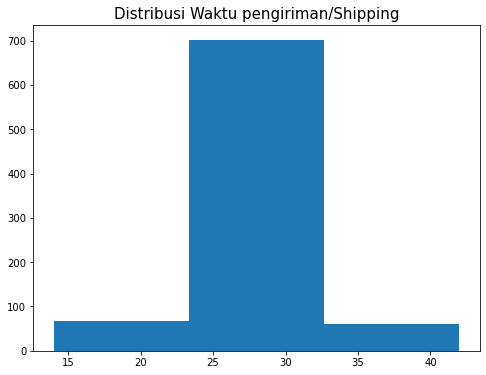

In [53]:
plt.figure(figsize=(8,6))
plt.hist(df['ShippingTime'], bins=3)
plt.title('Distribusi Waktu pengiriman/Shipping', size=15)
plt.show()

* Visualisasi diatas merupakan persebaran/distribusi dari waktu pengiriman dari semua Perusahaan Pengiriman

## Hypothesis Testing
Apakah perbedaan signifikan secara statistik antara perusahaan pengiriman berdasarkan waktu pengiriman ?

Untuk Pengujian ini kita melakukan pengujian Anova test. metode pengijian ini dipilih karena data Shipping Time yang digunakan dianggap terdistribusi normal sehingga metode statistik yang digunakan adalah metode statistik parametrik.

* H0 : Perbedaan rata-rata waktu pengiriman (Shipping Time) dari ketika perusahaan adalah sama X1 = X2 = X3
* HA : Perbedaan rata-rata waktu pengiriman (Shipping Time) dari ketika perusahaan adalah sama tidak sama X1 != X2 != X3

Hypothesis Testing ini menggunakan Two tailed testing dan nilai alpha = 0.05

In [16]:
stat, pvalAnova = f_oneway(df[df['CompanyName'] == 'Federal Shipping']['ShippingTime'],
                            df[df['CompanyName'] == 'Speedy Express']['ShippingTime'],
                            df[df['CompanyName'] == 'United Package']['ShippingTime'])
if pvalAnova < 0.05:
    print('Tolak H0')
else:
    print('Terima H0')
print(pvalAnova)

Terima H0
0.4261631402701971


Setelah melakukan ANOVA test, kita tidak memiliki cukup bukti untuk menolak H0 dengan nilai confidence interval 95 % dan nilai alpha 0.05 sehingga nilai rata-rata perbedaan setiap shipping company tidak berbeda signifikan secara statistik

## 2. Apakah pilihan Dari Perusahaan pengiriman memiliki pengaruh pada Biaya Kargo ?

### Data Cleaning

Skewness Score : 6.840823060120213


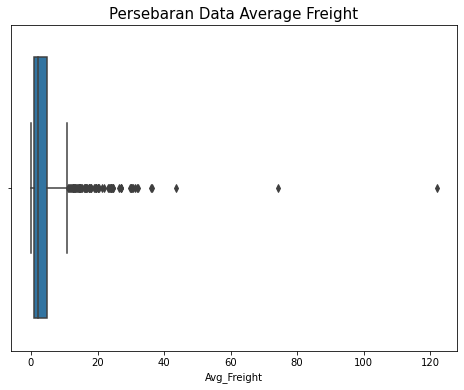

In [55]:
# mengecek data outlier pada data target Avg_Freight
plt.figure(figsize=(8,6))
sns.boxplot(x=df['Avg_Freight'])
plt.title('Persebaran Data Average Freight', size=15)
print("Skewness Score : {}".format(df['Avg_Freight'].skew()))

### Skewness
* Berdasarkan plot, Skewness Score adalah 6.84, hal ini mengindikasikan bahwa data memilikiki skewness yang tinggi dan berbentuk positive skewness dimana hal ini mengakibatkan mode dari data lebih kecil dari mean atau median.

In [18]:
# Outliers handling
df['Avg_Freight'].describe()

count    830.000000
mean       4.403661
std        7.539281
min        0.000000
25%        0.829762
50%        2.200000
75%        4.887500
max      122.000000
Name: Avg_Freight, dtype: float64

* pada kolom Avg_Freight memiliki nilai yang jauh antara quantile 75% dengan nilai maksimum data hal ini mengindikasikan bahwa data Avg_Freight memiliki outlier

In [19]:
# defining quantile
Q1 =  df['Avg_Freight'].quantile(0.25)
Q3 = df['Avg_Freight'].quantile(0.75)
IQR =Q3 - Q1
# defining lower and upper limit
lower_lim = Q1 - 1.5 * IQR
upper_lim = Q3 + 1.5 * IQR
# selecting data from lower to upper range
outlier_df_low = (df['Avg_Freight'] < lower_lim)
outlier_df_up = (df['Avg_Freight'] > upper_lim)

Proses mendapatkan nilai kuantil bawah dan kuantil atas

In [20]:
df['Avg_Freight_win'] = winsorize(df['Avg_Freight'], (0.01, 0.02))
df['Avg_Freight_win'].describe()

count    830.000000
mean       4.143789
std        5.546465
min        0.000000
25%        0.829762
50%        2.200000
75%        4.887500
max       26.500000
Name: Avg_Freight_win, dtype: float64

Terdapat beberapa metode untuk mengatasi outlier salah satunya dengan menghapus data outlier, cara ini tidak dipilih karena dikhawatirkan akan semakin mengurangi data-data outlier yang nantinya akan mengakibatkan semakin kurang akuratnya hasil pengolahan data. lalu metode log Transformation metode ini lebih umum digunakan pada machine learning tetapi metode ini akan melakukan transofrmasi pada data sehingga ditakutkan dapat menghilangkan informasi pada data awal.

Sehingga pada pengujian kali ini kita menggunakan metode Winsorize. hal ini dikarenakan metode ini tidak mengurangi jumlah data yang ada dan tidak mentranformasi data yang ada.

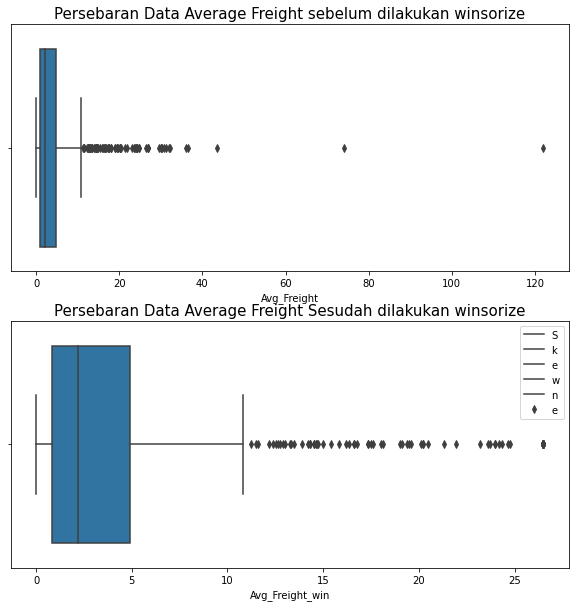

Skewness Data sebelum winsorize : 6.840823060120213
Skewness Data sesudah winsorize : 2.438069786476271


In [56]:
# Perbandingan persebaran data sebelum dan sesudah metode winsorize
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.boxplot(x=df['Avg_Freight'])
plt.title('Persebaran Data Average Freight sebelum dilakukan winsorize', size=15)
plt.subplot(2,1,2)
sns.boxplot(x=df['Avg_Freight_win'])
plt.title('Persebaran Data Average Freight Sesudah dilakukan winsorize', size=15)
plt.legend("Skewness data : {}".format(df['Avg_Freight_win'].skew()))
plt.show()

skewnes_1 = df['Avg_Freight'].skew()
skewnes_2 = df['Avg_Freight_win'].skew()
print("Skewness Data sebelum winsorize : {}".format(skewnes_1))
print("Skewness Data sesudah winsorize : {}".format(skewnes_2))

Skewness Analysis : 

In [22]:
all_companies = df['Avg_Freight_win']
federal = df[df['CompanyName'] == 'Federal Shipping']['Avg_Freight_win']
speedy = df[df['CompanyName'] == 'Speedy Express']['Avg_Freight_win']
united = df[df['CompanyName'] == 'United Package']['Avg_Freight_win']

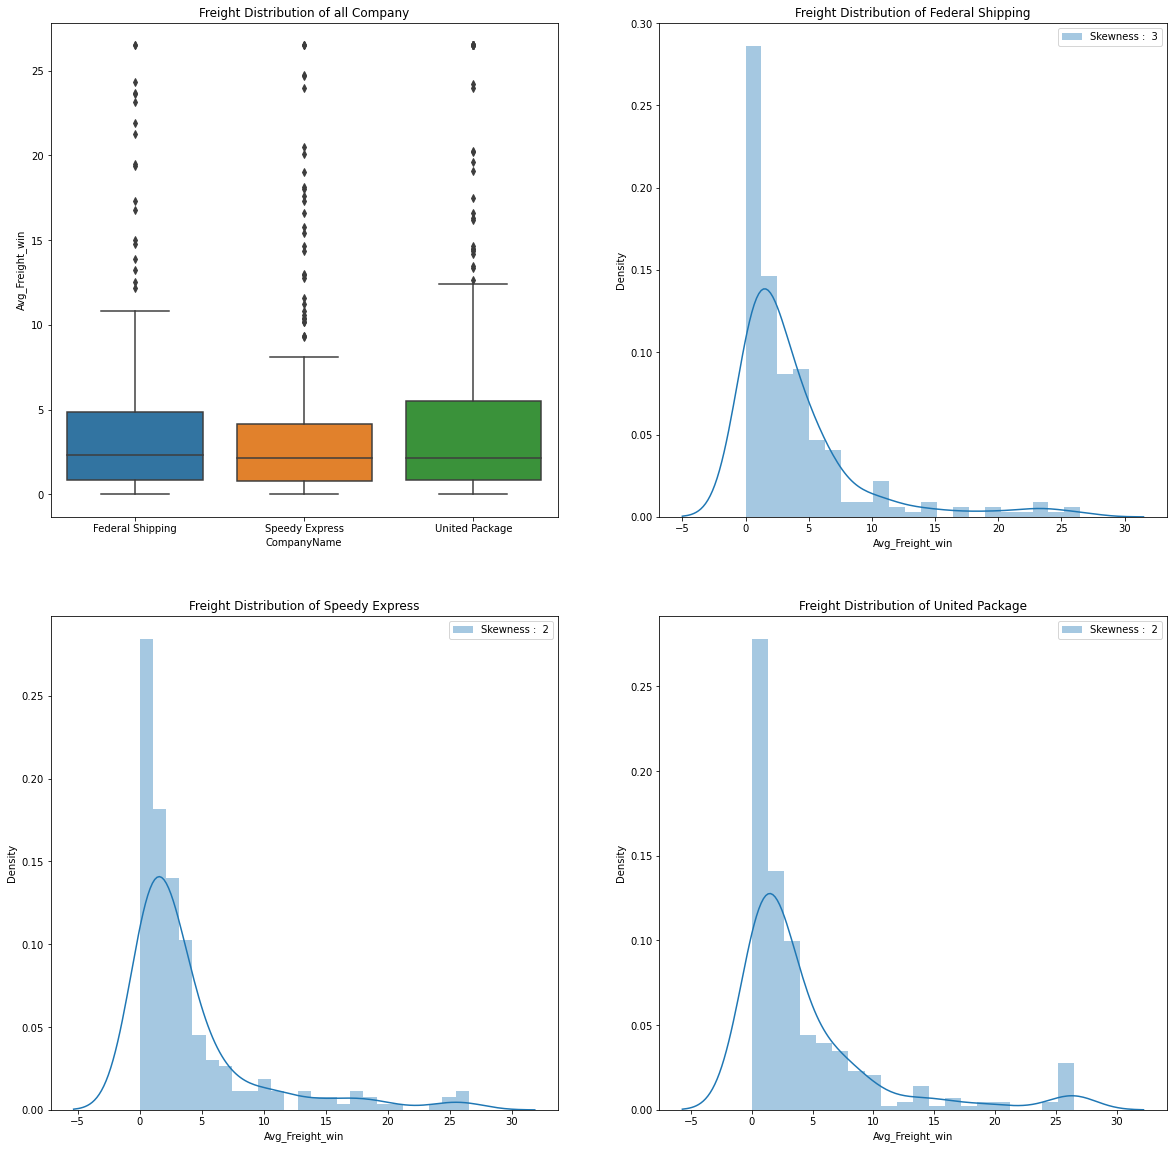

In [23]:
# Checking the distribution plots

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.boxplot(y=df['Avg_Freight_win'], x=df['CompanyName'])
plt.title('Freight Distribution of all Company')
plt.subplot(2,2,2)
sns.distplot(federal, label='Skewness : %2.f'%(federal.skew()))
plt.legend(loc=0, fontsize=10)
plt.title('Freight Distribution of Federal Shipping')
plt.subplot(2,2,3)
sns.distplot(speedy, label='Skewness : %2.f'%(speedy.skew()))
plt.legend(loc=0, fontsize=10)
plt.title('Freight Distribution of Speedy Express')
plt.subplot(2,2,4)
sns.distplot(united, label='Skewness : %2.f'%(united.skew()))
plt.legend(loc=0, fontsize=10)
plt.title('Freight Distribution of United Package')
plt.show()

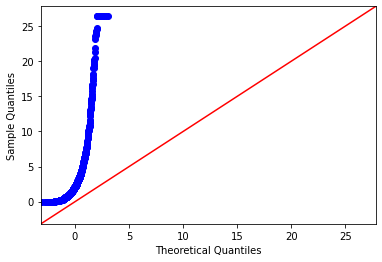

Data Tidak Terdistribusi Normal


In [24]:
# melakukan uji normalitas pada Avg Freight
sm.qqplot(df['Avg_Freight_win'], line='45')
plt.show()
stat ,pval= normaltest(df['Avg_Freight_win'])
if pval > 0.05:
    print('Data Terdistribusi Normal')
else:
    print('Data Tidak Terdistribusi Normal')

* Berdasarkan QQ plot dan Normal test ini dapat dismpulkan Bahwa data Avg Freight tidak terdistribusi normal
* Sehingga untuk Hypothesis Testing kita menggunakan pengukuran Statistik non-parametric
* Walaupun telah dilakukan metode Winsorize untuk menangani data outlier. dapat dilihat bahwa Skewness dari data berkurang berdasarkan Score Skewness yang awalnya bernilai 6.84 menjadi 2.43
* Walaupun Begitu masih terdapat data outlier pada visualisasi menggunakan boxplot dan distplot diatas hal ini tidak menjadi masalah karena metode statistik non-parametrik yang akan kita gunakan tidak sensitif pada data outliers.

## Hypothesis Testing

Apakah pilihan Dari Perusahaan pengiriman memiliki pengaruh pada Biaya Kargo ?

Untuk Pengujian ini kita melakukan pengujian Wilcoxon test. metode pengijian ini dipilih karena data Average Freight yang digunakan tidak terdistribusi normal sehingga metode statistik yang digunakan adalah metode statistik non parametrik.

* H0 : Perbedaan Median terhadap rata-rata biaya kargo dari semua perusahaan pengiriman adalah sama X0 = X1
* HA : Perbedaan Median terhadap rata-rata biaya kargo dari semua perusahaan pengiriman adalah tidak sama X0 != X1

Hypothesis Testing ini menggunakan Two tailed testing dan nilai alpha = 0.05


Karena jumlah dari data setiap perusahaan tidaklah sama maka kita akan mengambil sample dari setiap data 

In [25]:
def get_sample(data, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(data)
        sample.append(x)
    
    return sample
def get_sample_mean(sample):
    return sum(sample) / len(sample)
def create_sample_distribution(data, dist_size=100, n=30):
    sample_dist = []
    while len(sample_dist) != dist_size:
        sample = get_sample(data, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
    
    return sample_dist

In [26]:
all_companies_sample = create_sample_distribution(all_companies, 1000,30)
federal_sample = create_sample_distribution(federal, 1000, 30)
speedy_sample = create_sample_distribution(speedy, 1000, 30)
united_sample = create_sample_distribution(united, 1000, 30)

In [27]:
companies_data = [federal_sample, speedy_sample, united_sample]
pval_list=[]
for i in range(len(companies_data)):
    sumrank, pval = wilcoxon(all_companies_sample, companies_data[i], alternative='two-sided')
    pval_list.append(pval)

pval_df= pd.DataFrame({'Company':['Federal Shipping', 'Speedy Express', 'United Package'],
'P_Value':pval_list})
pval_df['Hypothesis'] =np.where(pval_df['P_Value'] < 0.05, 'Tolak H0', 'Terima HA')

pval_df

,Company,P_Value,Hypothesis
0,Federal Shipping,1.099255e-05,Tolak H0
1,Speedy Express,8.085516e-05,Tolak H0
2,United Package,5.133280e-08,Tolak H0


Semua hasil pengujian menunjukan hasil yang kurang dari nilai alpha, sehingga kita memiliki cukup bukti untuk menolak Hipotesis H0. hal ini membuktikan bahwa perbedaan median dari average freight dari setiap perusahaan pengiriman tidaklah sama dengan kata lain pemilihan perusahaan pengiriman memiliki pengaruh pada harga average Freight.

Sekarang kita melakukan pengetesan untuk mengetahui perusahaan pengiriman mana yang lebih mahal dengan hypothesis sebagai berikut
- H0 : perbedaan median dari average freight cost dari 1 perusahaan dengan perusahaan lainnya adalah 0 X0 =X1
- HA : perbedaan median dari average freight cost dari 1 perusahaan dengan perusahaan lainnya adalah tidak 0 X0 !=X1

In [50]:
# melakukan Wilcoxon Test antara data Federal Shipping dengan Speedy Express
sumrank, pval = wilcoxon(federal_sample, speedy_sample, alternative='two-sided')
if pval < 0.05:
    print('Tolak H0')
else:
    print('Terima H0')
print(pval)

Terima H0
0.5198095422591804


Berdasarkan uji hipotesis antara federal Shipping dan Speedy Express memiliki nilai p-value yang dihasilkan lebih besar dari 0.05. sehingga kita tidak memiliki cukup bukti untuk menolak hipotesis H0. dengan kata lain perbedaan dari nilai median antara perusahaan Federal Shipping dan Speedy Express adalah 0. atau nilai median dari kedua perusahaan ini adalah sama.

In [29]:
# melakukan Wilcoxon Test antara data Federal Shipping dengan United Package
sumrank, pval = wilcoxon(federal_sample, united_sample, alternative='two-sided')
if pval < 0.05:
    print('Tolak H0')
else:
    print('Terima H0')

Tolak H0


Berdasarkan uji hipotesis antara federal Shipping dan United Package memiliki nilai p-value yang dihasilkan kurang dari 0.05. sehingga kita memiliki cukup bukti untuk menolak hipotesis H0. dengan kata lain perbedaan dari nilai median antara perusahaan Federal Shipping dan United Package adalah tidak 0. atau nilai median dari kedua perusahaan ini adalah tidak lah sama.

In [30]:
# melakukan Wilcoxon Test antara data Speedy Express dengan United Package
sumrank, pval = wilcoxon(speedy_sample, united_sample, alternative='two-sided')
if pval < 0.05:
    print('Tolak H0')
else:
    print('Terima H0')

Tolak H0


Berdasarkan uji hipotesis antara Speedy Express dan United Package memiliki nilai p-value yang dihasilkan kurang dari 0.05. sehingga kita memiliki cukup bukti untuk menolak hipotesis H0. dengan kata lain perbedaan dari nilai median antara perusahaan Speedy Express dan United Package adalah tidak 0. atau nilai median dari kedua perusahaan ini adalah tidak lah sama.

In [43]:
Avg_freight_df = df[['CompanyName', 'Avg_Freight_win']]
Avg_freight_df['Avg_Freight_win'].groupby(Avg_freight_df['CompanyName']).median()

CompanyName
Federal Shipping    2.300000
Speedy Express      2.166667
United Package      2.150000
Name: Avg_Freight_win, dtype: float64

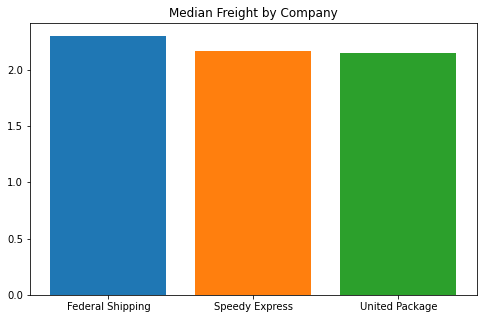

In [45]:
plt.figure(figsize=(8,5))
plt.title('Median Freight by Company')

comapanies = df['CompanyName'].unique()
for company in comapanies:
    plt.bar(company, df[df['CompanyName']==company]['Avg_Freight_win'].median())

plt.show()

Berdasarkan pengamatan ini Speedy Express memiliki harga rata-rata terendah dari yang lainnya